In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
datafilename1 = "C:\\Users\\Administrator\\Desktop\\database\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']

In [4]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Model

# 定义残差块，使用膨胀卷积
def residual_block_tcn(x, filters, kernel_size, dilation_rate):
    shortcut = x
    
    # 膨胀卷积路径
    x = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    x = BatchNormalization()(x)
    
    # 如果shortcut的形状与x不匹配，则调整shortcut
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # 添加残差连接
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

# 定义TCN模型
def tcn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # 初始卷积层，不使用膨胀卷积
    x = Conv1D(32, 31, padding='causal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 添加多个残差块，膨胀率倍增
    x = residual_block_tcn(x, 32, 5, dilation_rate=1)
    x = residual_block_tcn(x, 64, 5, dilation_rate=2)
    x = residual_block_tcn(x, 128, 5, dilation_rate=4)
    x = residual_block_tcn(x, 256, 5, dilation_rate=8)
    
    # 分类层
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

# Example usage:
model = tcn((4500, 1), 4)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4500, 32)     1024        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4500, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 4500, 32)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
import tensorflow as tf

def weighted_crossentropy(weights):
    def loss(y_true, y_pred):
        # 计算未加权的交叉熵损失
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        # 应用类别权重
        weighted_loss = unweighted_loss * weights
        # 返回加权损失
        return weighted_loss
    return loss
class_weights = [2.0, 1.0, 1.5, 1.0] 

In [7]:
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss=weighted_crossentropy(class_weights), metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=128, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Epoch 1/80
110/110 [==============================] - 61s 418ms/step - loss: 1.1254 - accuracy: 0.6303 - val_loss: 1.0695 - val_accuracy: 0.6599
Epoch 2/80
110/110 [==============================] - 45s 406ms/step - loss: 0.9537 - accuracy: 0.6912 - val_loss: 0.9518 - val_accuracy: 0.6850
Epoch 3/80
110/110 [==============================] - 45s 407ms/step - loss: 0.8911 - accuracy: 0.7156 - val_loss: 1.0116 - val_accuracy: 0.6785
Epoch 4/80
110/110 [==============================] - 45s 408ms/step - loss: 0.8617 - accuracy: 0.7228 - val_loss: 0.8469 - val_accuracy: 0.7330
Epoch 5/80
110/110 [==============================] - 45s 409ms/step - loss: 0.8328 - accuracy: 0.7336 - val_loss: 0.8880 - val_accuracy: 0.7248
Epoch 6/80
110/110 [==============================] - 45s 409ms/step - loss: 0.8148 - accuracy: 0.7401 - val_loss: 0.8137 - val_accuracy: 0.7368
Epoch 7/80
110/110 [==============================] - 45s 409ms/step - loss: 0.7951 - accuracy: 0.7493 - val_loss: 0.8427 - val_ac

In [8]:
evaluate_model(model,X_test,y_test)

Precision: 0.7609634554938244
Recall: 0.6872310183152693
F1 Score: 0.7154928396595341
Accuracy: 0.8077232502011263
Class 1 - Precision: 0.8071748878923767, Recall: 0.7929515418502202, F1 Score: 0.7999999999999999
Class 2 - Precision: 0.8202710665880967, Recall: 0.927381745502998, F1 Score: 0.8705440900562852
Class 3 - Precision: 0.7735507246376812, Recall: 0.5785907859078591, F1 Score: 0.662015503875969
Class 4 - Precision: 0.6428571428571429, Recall: 0.45, F1 Score: 0.5294117647058824
Class 1 Accuracy: 0.9637972646822205
Class 2 Accuracy: 0.833467417538214
Class 3 Accuracy: 0.82461786001609
Class 4 Accuracy: 0.9935639581657281


In [9]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

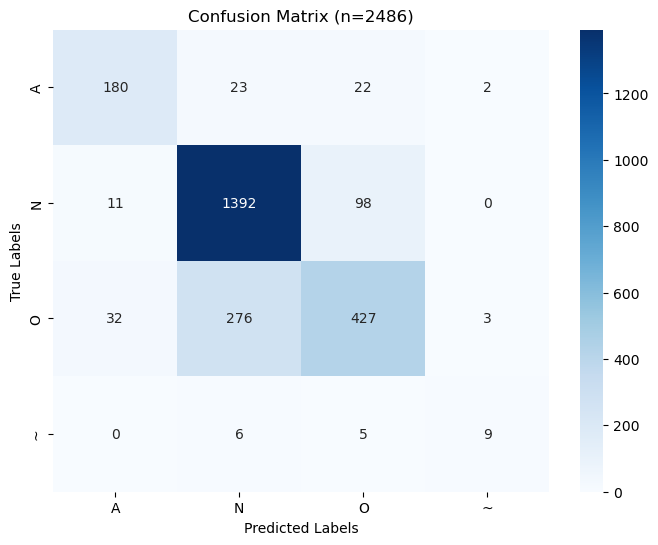

In [10]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])